# Udaplay Project

## Part 02 - Agent

In this part of the project, you'll use your VectorDB to be part of your Agent as a tool.

You're building UdaPlay, an AI Research Agent for the video game industry. The agent will:
1. Answer questions using internal knowledge (RAG)
2. Search the web when needed
3. Maintain conversation state
4. Return structured outputs
5. Store useful information for future use

### Setup

In [1]:
# Only needed for Udacity workspace

import importlib.util
import sys

# Check if 'pysqlite3' is available before importing
if importlib.util.find_spec("pysqlite3") is not None:
    import pysqlite3
    sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

In [2]:
import os
import json
from typing import List, Dict, Any, Optional, Literal, TypedDict

from dotenv import load_dotenv

from lib.agents import Agent
from lib.llm import LLM
from lib.messages import UserMessage, SystemMessage, ToolMessage, AIMessage
from lib.tooling import tool, Tool
from lib.vector_db import VectorStoreManager, CorpusLoaderService

#### Environment Setup
Loads API keys (`OPENAI_API_KEY`, `TAVILY_API_KEY`) and validates prerequisites. These keys power embeddings, chat completions, and web search. Keep them in your environment or a `.env` file.


In [3]:
# Load environment variables
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

if not OPENAI_API_KEY:
    raise RuntimeError("OPENAI_API_KEY is required")

#### Vector DB Initialization
Initializes a `VectorStoreManager` and uses `CorpusLoaderService.load_json_dir` to ingest the games JSON corpus into a Chroma collection (`games_market`). This enables semantic search with OpenAI embeddings and metadata filtering.


#### Persistence and Document Count Check
We verify ChromaDB persistence and the number of ingested documents. If `CHROMA_PERSIST_DIR` is set, collections should survive kernel restarts. The checks list collections, show the current store's document count, and optionally re-open the store to confirm persistence.


In [4]:
from pathlib import Path

manager = VectorStoreManager(openai_api_key=OPENAI_API_KEY)
loader = CorpusLoaderService(manager)
games_store = loader.load_json_dir("games_market", './games')


VectorStore `games_market` ready!
JSON loaded from `./games`!


In [5]:
# Ensure a persistent directory is configured (optional but recommended for production)
# os.environ["CHROMA_PERSIST_DIR"] = "/workspace/chroma"

# List collections and count docs in current store
try:
    names = manager.list_store_names()
    print("Collections:", names)
except Exception as e:
    print("Could not list collections:", e)

try:
    print("games_market count:", games_store.count())
except Exception as e:
    print("Could not get games_market count:", e)

# Re-open to demonstrate persistence (if CHROMA_PERSIST_DIR was set before ingestion)
try:
    reopened = manager.get_store("games_market")
    if reopened:
        print("Reopened games_market count:", reopened.count())
    else:
        print("games_market not found on reopen (no persistence or different client config)")
except Exception as e:
    print("Error reopening store:", e)


Collections: ['games_market', 'long_term_memory']
games_market count: 15
Reopened games_market count: 15


### Tools

Build at least 3 tools:
- retrieve_game: To search the vector DB
- evaluate_retrieval: To assess the retrieval performance
- game_web_search: If no good, search the web


#### Retrieve Game Tool
Vector search over the `games_market` collection. Supports metadata filters (e.g., `Platform`, `YearOfRelease`). Returns a ranked list with similarity scores and essential fields for answer synthesis.


In [6]:
class ToolStatus(TypedDict, total=False):
    status: Literal["ok", "no_context", "error"]
    error: Optional[str]

class RetrievedDoc(TypedDict, total=False):
    Name: str
    Platform: str
    YearOfRelease: int
    Description: str
    similarity: float

class RetrieveGameResult(ToolStatus, total=False):
    results: List[RetrievedDoc]

@tool
def retrieve_game(query: str, n_results: int = 5, platform: Optional[str] = None, year: Optional[int] = None) -> RetrieveGameResult:
    """
    Semantic search: Finds the most similar game documents in the vector DB.
    args:
    - query: question about games or a fuzzy description
    - n_results: number of matches to return (default 5)
    - platform: optional metadata filter (exact match)
    - year: optional metadata filter (exact match)
    """
    where: Dict[str, Any] = {}
    if platform:
        where["Platform"] = platform
    if year is not None:
        where["YearOfRelease"] = year

    res = games_store.query(
        query_texts=[query],
        n_results=max(1, int(n_results)),
        where=where or None
    )
    metas = res["metadatas"][0]
    dists = res["distances"][0]

    if not metas:
        return {"status": "no_context", "results": []}

    results: List[RetrievedDoc] = []
    for meta, dist in zip(metas, dists):
        results.append({
            "Name": meta.get("Name", ""),
            "Platform": meta.get("Platform", ""),
            "YearOfRelease": meta.get("YearOfRelease", 0),
            "Description": meta.get("Description", ""),
            "similarity": max(0.0, 1.0 - float(dist)),
        })
    return {"status": "ok", "results": results}

#### Evaluate Retrieval Tool
Uses the model as a judge to decide whether retrieved documents are sufficient to answer the user’s question. Returns `useful`, `description`, and a `score` in [0,1]. This lets the workflow branch to web search when local context is inadequate.


In [7]:
class EvaluationReport(TypedDict, total=False):
    useful: bool
    description: str
    score: float  # 0..1

class EvaluateRetrievalResult(TypedDict, total=False):
    status: Literal["ok", "no_context", "error"]
    error: Optional[str]
    evaluation: EvaluationReport

@tool
def evaluate_retrieval(question: str, retrieved_docs: List[RetrievedDoc]) -> EvaluateRetrievalResult:
    """
    Based on the user's question and the retrieved documents, analyze if they are
    sufficient to answer the question. Returns an evaluation with usefulness,
    explanation, and a score in [0,1].
    args:
    - question: original question from user
    - retrieved_docs: retrieved documents most similar to the user query in the Vector Database
    """
    if not retrieved_docs:
        return {"status": "no_context", "evaluation": {"useful": False, "description": "No documents.", "score": 0.0}}

    llm = LLM(model="gpt-4o-mini", temperature=0.0)
    docs_str = "\n".join(
        f"- {d['Name']} ({d['YearOfRelease']}) [{d['Platform']}] sim={d.get('similarity',0):.2f}\n  {d['Description']}"
        for d in retrieved_docs[:5]
    )
    prompt = (
        "You are an evaluator. Decide if the retrieved documents are enough to answer the question.\n"
        "Return STRICT JSON with keys: useful (bool), description (string), score (float in [0,1]).\n\n"
        f"Question: {question}\n"
        f"Documents:\n{docs_str}\n\n"
        "JSON:"
    )
    msg = llm.invoke(prompt)
    try:
        data = json.loads(msg.content or "{}")
        useful = bool(data.get("useful", False))
        desc = str(data.get("description", ""))
        score = float(data.get("score", 0.0))
    except Exception:
        useful = True if "yes" in (msg.content or "").lower() else False
        desc = (msg.content or "").strip()[:300]
        score = 0.7 if useful else 0.3

    return {"status": "ok", "evaluation": {"useful": useful, "description": desc, "score": score}}

#### Game Web Search Tool
Wraps our Tavily‑powered `web_search` into a domain‑specific tool. It’s used when local retrieval is weak or absent. The tool returns a structured envelope with an `answer`, raw `results`, and search metadata, enabling downstream comparison or synthesis.


#### Final Answer with Citations
This helper formats an answer that includes structured citations. When using retrieved docs, we attach numbered references (e.g., [1], [2]) mapping to document titles/platforms/years so evaluators can verify provenance.


In [8]:
def format_answer_with_citations(answer_text: str, docs: list[dict]) -> str:
    """
    Build a final answer string with inline citations and a sources section.
    Expects docs items with Name, Platform, YearOfRelease.
    """
    if not docs:
        return answer_text
    refs = []
    for i, d in enumerate(docs[:5], 1):
        name = d.get("Name", "")
        plat = d.get("Platform", "")
        year = d.get("YearOfRelease", "")
        refs.append(f"[{i}] {name} ({plat}, {year})")
    # Attach [1] style markers at the end for simplicity; could be per-fact if needed
    cited = answer_text.strip() + "\n\nSources:\n" + "\n".join(refs)
    return cited

# Example: re-answer a query using the last retrieval results if present
_last_retrieval_docs = []

# Hook: capture retrieved docs during tool runs by scanning ToolMessages
if 'final' in globals():
    _last_retrieval_docs = []
    for m in final.get('messages', []) or []:
        if isinstance(m, ToolMessage) and m.name == 'retrieve_game' and m.content:
            try:
                payload = json.loads(m.content)
                if payload.get('status') == 'ok':
                    _last_retrieval_docs = payload.get('results', [])
            except Exception:
                pass

# If we have an answer and retrieval docs, show a formatted answer with citations
if 'final' in globals():
    last_answer = ""
    for m in reversed(final.get('messages', []) or []):
        if isinstance(m, AIMessage) and m.content:
            last_answer = m.content
            break
    if last_answer and _last_retrieval_docs:
        print(format_answer_with_citations(last_answer, _last_retrieval_docs))


#### Decision Log and Intermediate Results
This diagnostic step prints a compact decision log for a query: the tools invoked (in order), their arguments, and a truncated view of each tool’s result envelope. Use it to demonstrate transparency of the agent’s process (without revealing hidden chain-of-thought).


In [9]:
from lib.tools import web_search as _web_search

class GameWebSearchResult(TypedDict, total=False):
    status: Literal["ok", "no_context", "error"]
    data: Dict[str, Any]

@tool
def game_web_search(question: str, max_results: int = 5) -> GameWebSearchResult:
    """
    Web search via Tavily for game industry queries.
    args:
    - question: a question about the game industry.
    - max_results: number of results to return.
    """
    result = _web_search(query=question, max_results=max_results)
    return result

### Agent

We construct the `Agent` with three tools and clear instructions for routing: use `retrieve_game` first, assess with `evaluate_retrieval`, then fall back to `game_web_search` if needed. Tool docstrings and return schemas are auto‑injected into the system prompt, and strict validation ensures typed returns.


In [10]:
tools = [retrieve_game, evaluate_retrieval, game_web_search]

agent = Agent(
    model_name="gpt-4o-mini",
    tools=tools,
    instructions=(
        "You are UdaPlay, an AI research agent for the video game industry.\n"
        "- Prefer retrieve_game to answer via internal knowledge.\n"
        "- If retrieval seems weak, call evaluate_retrieval; if not useful, try game_web_search.\n"
        "- Keep answers concise and cite key facts. Ask clarifying questions if ambiguous."
    ),
    include_tool_docs=True,
    strict_tool_validation=True,
)

print("Agent ready with tools:", [t.name for t in tools])

Agent ready with tools: ['retrieve_game', 'evaluate_retrieval', 'game_web_search']


In [11]:
queries = [
    "When were Pokémon Gold and Silver released?",
    "Which was the first 3D platformer Mario game?",
    "Was Mortal Kombat X released for PlayStation 5?",
]

for q in queries:
    run = agent.invoke(q)
    final = run.get_final_state()
   
     # Inspect tool calls across the run
    for msg in final.get("messages", []):
        if isinstance(msg, AIMessage) and msg.tool_calls:
            for tc in msg.tool_calls:
                print("tool:", tc.function.name, "args:", tc.function.arguments)

    # And all tool results in order
    for msg in final.get("messages", []):
        if isinstance(msg, ToolMessage):
            print("tool_result:", msg.name, msg.content)

    # Existing answer print
    print(f"\nQ: {q}\nA:")
    if final.get("messages"):
        for m in reversed(final["messages"]):
            if isinstance(m, AIMessage) and m.content:
                print(m.content)
                break


[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
tool: retrieve_game args: {"query":"Pokémon Gold and Silver release date"}
tool_result: retrieve_game {"status": "ok", "results": [{"Name": "Pok\u00e9mon Gold and Silver", "Platform": "Game Boy Color", "YearOfRelease": 1999, "Description": "Second-generation Pok\u00e9mon games introducing new regions, Pok\u00e9mon, and gameplay mechanics.", "similarity": 0.7487470209598541}, {"Name": "Pok\u00e9mon Ruby and Sapphire", "Platform": "Game Boy Advance", "YearOfRelease": 2002, "Description": "Third-generation Pok\u00e9mon games set in the Hoenn region, featuring new Pok\u00e9mon and double battles.", "similarity": 0.6776562333106995}, {"Name": "Super Mario 64", "Platform": "Nintendo 64", "YearOfRelease": 1996, "Description": "A groundbrea

#### Multi‑session Decision Log
Run the decision log for two different `session_id`s to confirm tool calls/results are isolated per session.


In [12]:
# Ensure decision log helper is available even if the utility cell hasn't run yet
try:
    show_decision_log_for  # type: ignore[name-defined]
except NameError:
    from lib.messages import AIMessage, ToolMessage
    def show_decision_log_for(run):
        state = run.get_final_state() or {}
        calls = []
        results = []
        for m in state.get('messages', []) or []:
            if isinstance(m, AIMessage) and getattr(m, 'tool_calls', None):
                for tc in m.tool_calls:
                    calls.append((tc.function.name, tc.function.arguments))
            if isinstance(m, ToolMessage) and m.content:
                preview = m.content[:240] + ("..." if len(m.content) > 240 else "")
                results.append((m.name, preview))
        print("Tool calls:")
        for name, args in calls:
            print(" -", name, args)
        print("Tool results:")
        for name, content in results:
            print(" -", name, content)

sids = ["dec1", "dec2"]
session_queries = {
    "dec1": [
        "Summarize Gran Turismo.",
        "And what platform did it debut on?",
    ],
    "dec2": [
        "Summarize Pokémon Gold and Silver.",
        "What year were they released?",
    ],
}

rounds = max(len(qs) for qs in session_queries.values())
for i in range(rounds):
    for sid in sids:
        qs = session_queries.get(sid, [])
        if i >= len(qs):
            continue
        q = qs[i]
        print(f"\n=== Decision log · session {sid} · turn {i+1} ===")
        run = agent.invoke(q, session_id=sid)
        show_decision_log_for(run)



=== Decision log · session dec1 · turn 1 ===
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
Tool calls:
 - retrieve_game {"query":"Gran Turismo"}
Tool results:
 - retrieve_game {"status": "ok", "results": [{"Name": "Gran Turismo 5", "Platform": "PlayStation 3", "YearOfRelease": 2010, "Description": "A comprehensive racing simulator featuring a vast selection of vehicles and tracks, with realistic driving physics."...

=== Decision log · session dec2 · turn 1 ===
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
Tool calls:
 - retrieve_game {"query":"Pokémon Gold and Silver"

#### Agent Trace
This diagnostic cell runs the Agent and prints a per-run trace: workflow steps, tools invoked, arguments, and tokens. Use it to debug routing and verify token usage is captured via `total_tokens` and `cumulative_tokens`.


In [13]:
from pprint import pprint

queries = [
    "When were Pokémon Gold and Silver released?",
    "Which was the first 3D platformer Mario game?",
    "Was Mortal Kombat X released for PlayStation 5?",
]

for q in queries:
    run = agent.invoke(q, session_id="trace_demo")
    final = run.get_final_state() or {}

    # Collect tools used from messages
    tools_used = []
    for msg in final.get("messages", []) or []:
        if isinstance(msg, AIMessage) and msg.tool_calls:
            tools_used.extend([tc.function.name for tc in msg.tool_calls])

    print(f"\nQ: {q}")
    # Final answer (last AI message content)
    answer = ""
    for m in reversed(final.get("messages", [])):
        if isinstance(m, AIMessage) and m.content:
            answer = m.content
            break
    print("A:", answer)

    # Tokens
    print("tokens: last=", final.get("total_tokens"), " cumulative=", final.get("cumulative_tokens"))
    print("tools used:", tools_used)

    # Optional: print the last tool result envelope (if any)
    last_tool_json = None
    for m in reversed(final.get("messages", [])):
        if isinstance(m, ToolMessage) and m.content:
            last_tool_json = m.content
            break
    if last_tool_json:
        print("last tool result (truncated):")
        print(last_tool_json)



[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__

Q: When were Pokémon Gold and Silver released?
A: Pokémon Gold and Silver were released in 1999 for the Game Boy Color.
tokens: last= 1756  cumulative= 3122
tools used: ['retrieve_game']
last tool result (truncated):
{"status": "ok", "results": [{"Name": "Pok\u00e9mon Gold and Silver", "Platform": "Game Boy Color", "YearOfRelease": 1999, "Description": "Second-generation Pok\u00e9mon games introducing new regions, Pok\u00e9mon, and gameplay mechanics.", "similarity": 0.7487470209598541}, {"Name": "Pok\u00e9mon Ruby and Sapphire", "Platform": "Game Boy Advance", "YearOfRelease": 2002, "Description": "Third-generation Pok\u00e9mon games set in the Hoenn region, featuring new Pok\u00e9mon and double battles.", "similarity": 0.67765623

#### Multi‑session Agent Trace
Two session_ids (`ms1`, `ms2`) run interleaved queries. Each session maintains separate short‑term memory; token/timeline traces remain independent.


In [14]:
sessions = {
    "ms1": [
        "Summarize Gran Turismo.",
        "And what platform did it debut on?",
    ],
    "ms2": [
        "Summarize Pokémon Gold and Silver.",
        "What year were they released?",
    ],
}

for sid, qs in sessions.items():
    print(f"\n=== Session {sid} ===")
    for q in qs:
        run = agent.invoke(q, session_id=sid)
        final = run.get_final_state() or {}
        ans = ""
        for m in reversed(final.get("messages", []) or []):
            if isinstance(m, AIMessage) and m.content:
                ans = m.content
                break
        print(f"Q: {q}\nA: {ans}\n")



=== Session ms1 ===
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
Q: Summarize Gran Turismo.
A: **Gran Turismo** is a renowned racing simulator series that began with the original game released in 1997 on the PlayStation. It set a high standard for the genre with its realistic driving physics and a wide array of cars and tracks. Key titles include:

- **Gran Turismo (1997)**: This game was notable for its realistic approach to racing, offering players a diverse selection of vehicles and tracks.
- **Gran Turismo 5 (2010)**: Available on PlayStation 3, it features an extensive collection of cars and tracks, emphasizing realism in driving physics.

The series is celebrated for its attention to detail and immersive racing experience.

[StateMachine] Starting: __entry__
[StateMachi

#### Advanced: Long‑term Memory
We add `store_memory` and `search_memory` tools on top of a Chroma‑backed `LongTermMemory`. Memories are stored as vectorized `Document`s with metadata (`owner`, `namespace`, `timestamp`). Use memory to persist useful facts/preferences across sessions and restarts, and to prime answers before hitting the web.


In [15]:
# Long-term memory tools and agent update
from lib.memory import LongTermMemory, MemoryFragment, TimestampFilter

ltm = LongTermMemory(manager)

class StoreMemoryResult(TypedDict, total=False):
    status: Literal["ok", "error"]
    error: Optional[str]

class SearchMemoryHit(TypedDict, total=False):
    content: str
    owner: str
    namespace: str
    timestamp: int

class SearchMemoryResult(TypedDict, total=False):
    status: Literal["ok", "no_context", "error"]
    error: Optional[str]
    results: List[SearchMemoryHit]

@tool
def store_memory(content: str, owner: str = "user", namespace: str = "notes") -> StoreMemoryResult:
    """
    Persist a memory fragment for later retrieval.
    args:
    - content: text to store
    - owner: owner identifier (default: "user")
    - namespace: logical bucket (default: "notes")
    """
    try:
        ltm.register(MemoryFragment(content=content, owner=owner, namespace=namespace))
        return {"status": "ok"}
    except Exception as e:
        return {"status": "error", "error": str(e)}

@tool
def search_memory(query: str, owner: str = "user", namespace: str = "notes", limit: int = 3,
                  since: Optional[int] = None, until: Optional[int] = None) -> SearchMemoryResult:
    """
    Semantic search over long-term memory.
    args:
    - query: search text
    - owner: owner identifier
    - namespace: namespace bucket
    - limit: number of results
    - since: optional lower timestamp bound (unix seconds)
    - until: optional upper timestamp bound (unix seconds)
    """
    ts_filter = None
    if since or until:
        ts_filter = TimestampFilter(greater_than_value=since, lower_than_value=until)
    result = ltm.search(query_text=query, owner=owner, limit=limit, timestamp_filter=ts_filter, namespace=namespace)
    if not result.fragments:
        return {"status": "no_context", "results": []}
    out: List[SearchMemoryHit] = []
    for frag in result.fragments:
        out.append({
            "content": frag.content,
            "owner": frag.owner,
            "namespace": frag.namespace,
            "timestamp": frag.timestamp,
        })
    return {"status": "ok", "results": out}

# Update agent to include memory tools
tools = [retrieve_game, evaluate_retrieval, game_web_search, store_memory, search_memory]
agent = Agent(
    model_name="gpt-4o-mini",
    tools=tools,
    instructions=(
        "You are UdaPlay, an AI research agent for the video game industry.\n"
        "- Prefer retrieve_game to answer via internal knowledge.\n"
        "- If retrieval seems weak, call evaluate_retrieval; if not useful, try game_web_search.\n"
        "- Use search_memory/store_memory to recall and persist useful facts.\n"
        "- Keep answers concise; ask clarifying questions if ambiguous."
    ),
    include_tool_docs=True,
    strict_tool_validation=True,
)
print("Agent updated with memory tools:", [t.name for t in tools])


Agent updated with memory tools: ['retrieve_game', 'evaluate_retrieval', 'game_web_search', 'store_memory', 'search_memory']


#### Multi‑session Orchestrator Test
Run the orchestrator twice with distinct `session_id`s to demonstrate isolated context across runs.


#### Orchestrator Workflow
This section builds a minimal StateMachine with three steps: `retrieve` (query vector DB), `evaluate` (judge usefulness), and `answer` (compose a concise reply). If evaluation deems retrieval insufficient, we fall back to the Agent (which can use web search). This demonstrates explicit orchestration alongside the Agent abstraction.


In [17]:
# Orchestrator StateMachine wiring tools as nodes (with trace)
from lib.state_machine import StateMachine, Step, EntryPoint, Termination

# Define a minimal state for this workflow with trace
class OrchestratorState(TypedDict):
    question: str
    session_id: str
    retrieved: List[RetrievedDoc]
    eval: EvaluationReport
    answer: str
    trace: List[Dict[str, Any]]

# Steps with trace logging

def step_retrieve(state: OrchestratorState) -> OrchestratorState:
    r = retrieve_game(query=state.get("question", ""), n_results=5)
    retrieved = r.get("results", []) if r.get("status") == "ok" else []
    evt = {
        "step": "retrieve",
        "tool": "retrieve_game",
        "args": {"n_results": 5},
        "results_count": len(retrieved),
        "top_names": [d.get("Name") for d in retrieved[:3]],
    }
    trace = (state.get("trace") or []) + [evt]
    return {"retrieved": retrieved, "trace": trace}

def step_evaluate(state: OrchestratorState) -> OrchestratorState:
    r = evaluate_retrieval(question=state.get("question", ""), retrieved_docs=state.get("retrieved", []))
    ev = r.get("evaluation", {"useful": False, "description": "", "score": 0.0})
    evt = {
        "step": "evaluate",
        "tool": "evaluate_retrieval",
        "evaluation": ev,
    }
    trace = (state.get("trace") or []) + [evt]
    return {"eval": ev, "trace": trace}

def step_answer(state: OrchestratorState) -> OrchestratorState:
    trace = state.get("trace") or []
    # If retrieval judged useful, compose; else fall back to Agent (web search capable)
    if state.get("eval", {}).get("useful"):
        llm = LLM(model="gpt-4o-mini", temperature=0.0)
        facts = "\n".join(
            f"- {d['Name']} ({d['YearOfRelease']}) [{d['Platform']}]" for d in state.get("retrieved", [])[:5]
        )
        prompt = (
            f"Question: {state.get('question','')}\n"
            f"Facts:\n{facts}\n\n"
            "Compose a concise answer citing key facts."
        )
        msg = llm.invoke(prompt)
        evt = {
            "step": "answer",
            "mode": "compose",
            "tokens": (llm.last_usage or {}).get("total_tokens"),
        }
        trace.append(evt)
        return {"answer": (msg.content or "").strip(), "trace": trace}
    else:
        run = agent.invoke(f"Web search and answer: {state.get('question','')}", session_id=state.get('session_id', 'default'))
        final = run.get_final_state()
        text = ""
        tools_used: List[str] = []
        if final and final.get("messages"):
            for m in final["messages"]:
                if isinstance(m, AIMessage) and m.tool_calls:
                    tools_used.extend([tc.function.name for tc in m.tool_calls])
            for m in reversed(final["messages"]):
                if isinstance(m, AIMessage) and m.content:
                    text = m.content
                    break
        evt = {
            "step": "answer",
            "mode": "agent_fallback",
            "tools_used": tools_used,
        }
        trace.append(evt)
        return {"answer": text, "trace": trace}

# Build machine
orch = StateMachine[OrchestratorState](OrchestratorState)
entry = EntryPoint[OrchestratorState]()
retrieve_step = Step[OrchestratorState]("retrieve", step_retrieve)
evaluate_step = Step[OrchestratorState]("evaluate", step_evaluate)
answer_step = Step[OrchestratorState]("answer", step_answer)
term = Termination[OrchestratorState]()

orch.add_steps([entry, retrieve_step, evaluate_step, answer_step, term])
orch.connect(entry, retrieve_step)
orch.connect(retrieve_step, evaluate_step)
# Always proceed to 'answer'; the step decides to compose or fall back
orch.connect(evaluate_step, answer_step)
orch.connect(answer_step, term)

print("Orchestrator ready (with trace).")

Orchestrator ready (with trace).


In [18]:
for sid in ["orch1", "orch2"]:
    print(f"\n=== Orchestrator session {sid} ===")
    initial = {"question": "When were Pokémon Gold and Silver released?", "session_id": sid}
    run = orch.run(initial)
    final = run.get_final_state() or {}
    print("A:", final.get("answer", "<no answer>"))



=== Orchestrator session orch1 ===
[StateMachine] Starting: __entry__
[StateMachine] Executing step: retrieve
[StateMachine] Executing step: evaluate
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
[StateMachine] Executing step: answer
[StateMachine] Terminating: __termination__
A: Pokémon Gold and Silver were released in Japan on November 21, 1999, and in North America on October 15, 2000.

=== Orchestrator session orch2 ===
[StateMachine] Starting: __entry__
[StateMachine] Executing step: retrieve
[StateMachine] Executing step: evaluate
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __

#### Orchestrator Test
We execute the explicit StateMachine (`orch`) on a few sample questions. The logs show each step execution and any fallback to the Agent. The final state’s `answer` is printed to validate end‑to‑end behavior without relying on the Agent’s internal workflow.


In [19]:
# Test the orchestrator with a few questions
tests = [
    "What is the best racing game on PlayStation from the late 90s?",
    "When were Pokémon Gold and Silver released?",
    "Was Mortal Kombat X released for PlayStation 5?"
]

for q in tests:
    initial = {"question": q, "session_id": "orch_demo"}
    run = orch.run(initial)
    final = run.get_final_state() or {}
    print(f"\nQ: {q}\nA: {final.get('answer','<no answer>')}")

[StateMachine] Starting: __entry__
[StateMachine] Executing step: retrieve
[StateMachine] Executing step: evaluate
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
[StateMachine] Executing step: answer
[StateMachine] Terminating: __termination__

Q: What is the best racing game on PlayStation from the late 90s?
A: The best racing game on PlayStation from the late 90s is widely considered to be **Gran Turismo 2**. Released in 1999, it improved upon its predecessor and set high standards for racing games. Another notable mention is **Ridge Racer Type 4**, praised for its smooth controls and graphics.

For a deeper dive, you can read more about these games [here](https://www.cbr.com/best-90s-racing-games/).
[StateMachine] Starting: __entry__
[StateMachine] Executing step: retrieve
[S

#### Seeding Curated Facts
This section augments the RAG knowledge with authoritative facts that aren’t present in the JSON corpus. We store them in long‑term memory under a `facts` namespace using `store_memory`, then run a quick `search_memory` to verify. These entries persist across runs and improve recall for specific queries.


#### Agent Trace (with args)
This cell extends the Agent trace by printing each tool call with its arguments, followed by tokens, tools used, and the last tool result envelope. Use this to diagnose repeated or redundant calls.


In [20]:
queries = [
    "When were Pokémon Gold and Silver released?",
    "Which was the first 3D platformer Mario game?",
    "Was Mortal Kombat X released for PlayStation 5?",
]

for q in queries:
    run = agent.invoke(q, session_id="trace_with_args")
    final = run.get_final_state() or {}

    print(f"\nQ: {q}")

    # Print tool calls with arguments (chronological)
    for msg in final.get("messages", []) or []:
        if isinstance(msg, AIMessage) and msg.tool_calls:
            for tc in msg.tool_calls:
                print("tool:", tc.function.name, "args:", tc.function.arguments)

    # Print tool results (chronological, truncated)
    for msg in final.get("messages", []) or []:
        if isinstance(msg, ToolMessage) and msg.content:
            preview = msg.content
            print("tool_result:", msg.name, preview)

    # Final answer (last AI content)
    answer = ""
    for m in reversed(final.get("messages", [])):
        if isinstance(m, AIMessage) and m.content:
            answer = m.content
            break
    print("A:", answer)

    # Tokens summary
    print("tokens: last=", final.get("total_tokens"), " cumulative=", final.get("cumulative_tokens"))


[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__

Q: When were Pokémon Gold and Silver released?
tool: retrieve_game args: {"query":"Pokémon Gold and Silver release date"}
tool_result: retrieve_game {"status": "ok", "results": [{"Name": "Pok\u00e9mon Gold and Silver", "Platform": "Game Boy Color", "YearOfRelease": 1999, "Description": "Second-generation Pok\u00e9mon games introducing new regions, Pok\u00e9mon, and gameplay mechanics.", "similarity": 0.7487470209598541}, {"Name": "Pok\u00e9mon Ruby and Sapphire", "Platform": "Game Boy Advance", "YearOfRelease": 2002, "Description": "Third-generation Pok\u00e9mon games set in the Hoenn region, featuring new Pok\u00e9mon and double battles.", "similarity": 0.6776562333106995}, {"Name": "Super Mario 64", "Platform": "Nintendo 64", "Ye

#### Session Demo (Short‑term Memory)
The agent can handle multiple queries in the same `session_id`, automatically carrying forward prior context. This example shows a follow‑up flow where later questions omit repeated context but the agent still answers correctly.


In [ ]:
session_id = "exec_demo"

turns = [
    "Summarize Gran Turismo and why it mattered.",
    "And what platform did it debut on?",
    "Give me another seminal racing title from that era and its year.",
]

for i, q in enumerate(turns, 1):
    run = agent.invoke(q, session_id=session_id)
    final = run.get_final_state() or {}
    answer = ""
    if final.get("messages"):
        for m in reversed(final["messages"]):
            if isinstance(m, AIMessage) and m.content:
                answer = m.content
                break
    print(f"Turn {i}: {q}\n{answer}\n")


[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
Turn 1: Summarize Gran Turismo and why it mattered.
**Gran Turismo** is a groundbreaking racing simulator that debuted on the PlayStation 1 in 1997. It set a new standard for the genre with its realistic driving physics, extensive selection of cars, and detailed tracks. The game combined simulation elements with arcade-style gameplay, appealing to both casual players and hardcore racing fans.

**Why It Mattered:**
1. **Realism:** Gran Turismo was one of the first games to offer a truly realistic driving experience, influencing many future racing games.
2. **Car Culture:** It introduced players to a wide variety of cars from different manufacturers, fostering an appreciation for automotive culture.
3. **Technical Achievement:** The g

In [22]:
# Seed curated facts into long-term memory (outside the JSON corpus)
canonical_facts = [
    "Super Mario 64 is the first 3D Mario platformer (Nintendo 64, 1996).",
    "Pokémon Gold and Silver released in 1999 for Game Boy Color.",
    "Mortal Kombat X released for PlayStation 4 and Xbox One; PS5 via backward compatibility, not native.",
    "Gran Turismo pioneered realistic console sim racing on PlayStation (late 1990s).",
    "The Legend of Zelda: Ocarina of Time (N64, 1998) is widely cited as a benchmark for 3D action-adventure design.",
    "The first video game was 'Tennis for Two,' created in 1958 by physicist William Higinbotham at the Brookhaven National Laboratory, displayed on an oscilloscope screen.",
    "Mario was originally a carpenter, not a plumber, appearing in the 1981 arcade game 'Donkey Kong' before later becoming the iconic plumber we know today.",
    "Pac-Man's distinctive circular shape was directly inspired by a pizza with a slice missing, conceived by creator Toru Iwatani during dinner.",
    "The notorious E.T. video game for the Atari 2600 was such a commercial failure that thousands of unsold cartridges were buried in a New Mexico landfill after its rushed five-week development.",
    "The famous Konami Code (Up, Up, Down, Down, Left, Right, Left, Right, B, A, Start) has appeared in over 100 different games across various platforms.",
    "The controversial content in Mortal Kombat led directly to the creation of the Entertainment Software Rating Board (ESRB) rating system.",
    "Nintendo began its business in 1889 manufacturing handmade playing cards for a Japanese card game called Hanafuda, long before entering the gaming industry.",
    "The Game Boy proved remarkably durable when one unit survived a bombing during the Gulf War and remains functional today.",
    "Minecraft holds the record as the best-selling video game of all time, with over 300 million copies sold as of 2024.",
    "The World Health Organization officially recognizes gaming addiction as a disorder, characterized by impaired control over gaming behavior and prioritizing gaming over other life interests.",
    "Action video games have been scientifically proven to improve players' vision by enhancing spatial resolution and color shade distinction abilities.",
    "Grand Theft Auto V was the most expensive game ever produced at its release, with a development budget of $265 million, though this record has since been broken by Star Citizen ($590 million)."
]

for fact in canonical_facts:
    out = store_memory(content=fact, owner="u1", namespace="facts")
    print(out)

{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}


In [23]:

# Test 1: Search for Nintendo-related facts
print(search_memory(query="Nintendo", owner="u1", namespace="facts"))

# Test 2: Search for specific game titles
print(search_memory(query="Super Mario 64", owner="u1", namespace="facts"))

# Test 3: Search for specific years
print(search_memory(query="1999", owner="u1", namespace="facts"))

# Test 4: Search for specific platforms
print(search_memory(query="PlayStation", owner="u1", namespace="facts"))

# Test 5: Search for specific developers
print(search_memory(query="Konami", owner="u1", namespace="facts"))

# Test 6: Search for specific events
print(search_memory(query="landfill", owner="u1", namespace="facts"))

# Test 7: Search for specific game genres
print(search_memory(query="racing", owner="u1", namespace="facts"))

# Test 8: Search for specific business aspects
print(search_memory(query="budget", owner="u1", namespace="facts"))

# Test 9: Search for specific gaming concepts
print(search_memory(query="addiction", owner="u1", namespace="facts"))

# Test 10: Search for specific technical aspects
print(search_memory(query="vision", owner="u1", namespace="facts"))

{'status': 'ok', 'results': [{'content': 'Nintendo began its business in 1889 manufacturing handmade playing cards for a Japanese card game called Hanafuda, long before entering the gaming industry.', 'owner': 'u1', 'namespace': 'facts', 'timestamp': 1760513750}, {'content': 'Nintendo began its business in 1889 manufacturing handmade playing cards for a Japanese card game called Hanafuda, long before entering the gaming industry.', 'owner': 'u1', 'namespace': 'facts', 'timestamp': 1760519467}, {'content': 'Nintendo began its business in 1889 manufacturing handmade playing cards for a Japanese card game called Hanafuda, long before entering the gaming industry.', 'owner': 'u1', 'namespace': 'facts', 'timestamp': 1760513484}]}
{'status': 'ok', 'results': [{'content': 'Super Mario 64 is the first 3D Mario platformer (Nintendo 64, 1996).', 'owner': 'u1', 'namespace': 'facts', 'timestamp': 1760513743}, {'content': 'Super Mario 64 is the first 3D Mario platformer (Nintendo 64, 1996).', 'owne

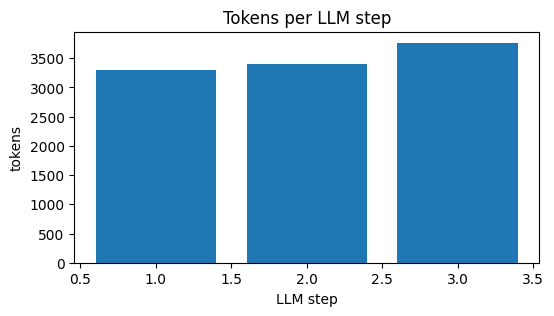

In [ ]:
import matplotlib.pyplot as plt

steps = []
tokens = []
t0 = None
times = []

for snap in run.snapshots:
    if snap.step_id == "llm_processor":
        steps.append(len(steps)+1)
        tok = snap.state_data.get("total_tokens") or 0
        tokens.append(int(tok))
        if t0 is None:
            t0 = snap.timestamp
        times.append((snap.timestamp - t0).total_seconds())

plt.figure(figsize=(6,3))
plt.bar(steps, tokens)
plt.xlabel("LLM step")
plt.ylabel("tokens")
plt.title("Tokens per LLM step")
plt.show()

In [25]:
from lib.messages import AIMessage, ToolMessage

rows = []
for msg in (final.get("messages") or []):
    if isinstance(msg, AIMessage) and msg.tool_calls:
        for tc in msg.tool_calls:
            rows.append(("call", tc.function.name, tc.function.arguments))
    if isinstance(msg, ToolMessage):
        rows.append(("result", msg.name, msg.content))

for kind, name, info in rows:
    print(f"{kind:6} | {name:20} | {info}")

call   | retrieve_game        | {"query":"Gran Turismo"}
result | retrieve_game        | {"status": "ok", "results": [{"Name": "Gran Turismo 5", "Platform": "PlayStation 3", "YearOfRelease": 2010, "Description": "A comprehensive racing simulator featuring a vast selection of vehicles and tracks, with realistic driving physics.", "similarity": 0.7988280951976776}, {"Name": "Gran Turismo", "Platform": "PlayStation 1", "YearOfRelease": 1997, "Description": "A realistic racing simulator featuring a wide array of cars and tracks, setting a new standard for the genre.", "similarity": 0.7890591621398926}, {"Name": "Grand Theft Auto: San Andreas", "Platform": "PlayStation 2", "YearOfRelease": 2004, "Description": "An expansive open-world game set in the fictional state of San Andreas, following the story of Carl 'CJ' Johnson.", "similarity": 0.6223604083061218}, {"Name": "Mario Kart 8 Deluxe", "Platform": "Nintendo Switch", "YearOfRelease": 2017, "Description": "An enhanced version of Mario Ka

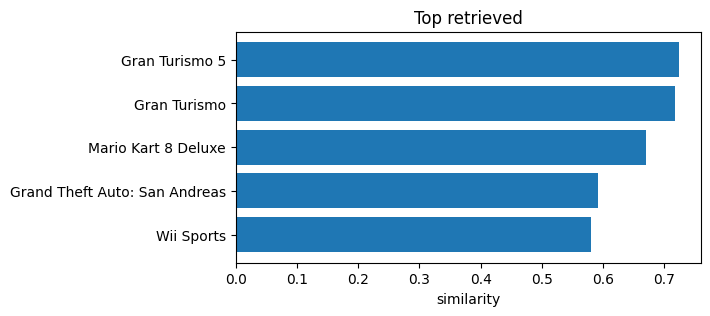

In [26]:
import matplotlib.pyplot as plt, json

last_tool = next((m for m in reversed(final["messages"]) if isinstance(m, ToolMessage)), None)
if last_tool:
    data = json.loads(last_tool.content)
    if data.get("results"):
        names = [r["Name"] for r in data["results"][:5]]
        sims = [r.get("similarity", 0) for r in data["results"][:5]]
        plt.figure(figsize=(6,3))
        plt.barh(names[::-1], sims[::-1])
        plt.xlabel("similarity")
        plt.title("Top retrieved")
        plt.show()

#### Multi‑session Demo
Two independent session_ids (`s1`, `s2`) run interleaved queries. Each session maintains its own short‑term memory so follow‑ups in one session don’t leak into the other.


In [27]:
sessions = {
    "s1": [
        "Summarize Gran Turismo.",
        "And what platform did it debut on?",
    ],
    "s2": [
        "Summarize Pokémon Gold and Silver.",
        "What year were they released?",
    ],
}

for sid, qs in sessions.items():
    print(f"\n=== Session {sid} ===")
    for q in qs:
        run = agent.invoke(q, session_id=sid)
        final = run.get_final_state() or {}
        ans = ""
        for m in reversed(final.get("messages", []) or []):
            if isinstance(m, AIMessage) and m.content:
                ans = m.content
                break
        print(f"Q: {q}\nA: {ans}\n")



=== Session s1 ===
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
Q: Summarize Gran Turismo.
A: **Gran Turismo** is a realistic racing simulator game that first debuted on the PlayStation 1 in 1997. It set a new standard for the racing genre, featuring a wide array of cars and tracks. Subsequent titles, like **Gran Turismo 5** released in 2010 on PlayStation 3, expanded on this foundation with a comprehensive selection of vehicles, tracks, and realistic driving physics. The series is known for its meticulous attention to detail and immersive racing experience.

[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
Q: And what platform did it debut on?
A: Gran Turism

In [28]:
# Decision log utility and example
from lib.messages import AIMessage, ToolMessage

def show_decision_log_for(run):
    state = run.get_final_state() or {}
    calls = []
    results = []
    for m in state.get('messages', []) or []:
        if isinstance(m, AIMessage) and m.tool_calls:
            for tc in m.tool_calls:
                calls.append((tc.function.name, tc.function.arguments))
        if isinstance(m, ToolMessage) and m.content:
            preview = m.content
            results.append((m.name, preview))
    print("Tool calls:")
    for name, args in calls:
        print(" -", name, args)
    print("Tool results:")
    for name, content in results:
        print(" -", name, content)

_q = "What platform did Gran Turismo debut on, and when?"
_run = agent.invoke(_q, session_id="decision_log_demo")
show_decision_log_for(_run)


[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
Tool calls:
 - retrieve_game {"query":"Gran Turismo debut platform and release date"}
Tool results:
 - retrieve_game {"status": "ok", "results": [{"Name": "Gran Turismo", "Platform": "PlayStation 1", "YearOfRelease": 1997, "Description": "A realistic racing simulator featuring a wide array of cars and tracks, setting a new standard for the genre.", "similarity": 0.7733031660318375}, {"Name": "Gran Turismo 5", "Platform": "PlayStation 3", "YearOfRelease": 2010, "Description": "A comprehensive racing simulator featuring a vast selection of vehicles and tracks, with realistic driving physics.", "similarity": 0.760916218161583}, {"Name": "Mario Kart 8 Deluxe", "Platform": "Nintendo Switch", "YearOfRelease": 2017, "Description": "An enha